In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# import sample video
from src.data_loader import load_triplets
video_triplets = load_triplets("data/public/backgrounds", "data/public/videos", "data/public/masks")
for video, mask, bg in video_triplets:
    print(video, mask, bg)
    break


data/public/videos/24_i_livingroom_leaves_mp.mp4 data/public/masks/24_i_livingroom_mp.png data/public/backgrounds/livingroom.png


In [14]:
video_sample_idx = 3
video_triplets[video_sample_idx]

(PosixPath('data/public/videos/2_i_kitchen_bridge_mp.mp4'),
 PosixPath('data/public/masks/2_i_kitchen_mp.png'),
 PosixPath('data/public/backgrounds/kitchen.png'))

In [15]:
# load sample video
from util import (load_video, load_background, load_mask)
sample = video_triplets[video_sample_idx]

video = dict(
    video=np.array(load_video(sample[0])),
    mask=load_mask(sample[1]),
    background=load_background(sample[2])
)
# video["video"]
print(sample[0])

data/public/videos/2_i_kitchen_bridge_mp.mp4


In [16]:
print(video["video"].shape)
print(video["mask"].shape)
print(video["background"].shape)
print(f"Video sample pixels: {video['video'][0][0]}")

(360, 720, 1280, 3)
(720, 1280)
(720, 1280, 3)
Video sample pixels: [[109  91  81]
 [109  91  81]
 [109  91  81]
 ..., 
 [ 99  78  57]
 [ 99  78  57]
 [ 98  77  56]]


In [17]:
# Check if all videos have the same shape
video_shapes = [load_mask(v[1]).shape for v in video_triplets]
if all(shape == video_shapes[0] for shape in video_shapes):
    print("All videos have the same shape:", video_shapes[0])
else:
    print("Videos have different shapes:", video_shapes)


# get the length of each video
# video_lengths = [len(load_video(v[0])) for v in video_triplets]
# print("Video lengths:", video_lengths)

# All videos have the same shape: (720, 1280)
# Video lengths: [699, 297, 298, 360, 240, 975, 373, 240, 704, 704, 298, 373, 704, 699, 360, 360, 699, 403, 975, 240, 361, 699, 704, 699, 704, 403, 360, 373, 403, 704, 360, 975, 699, 975, 297, 360, 240, 297, 975, 361, 298, 298, 403, 373, 704, 373, 373, 699, 361, 975, 361, 297, 297, 298, 298, 373, 361, 699, 975, 360, 240, 975, 240, 373, 403, 361, 403, 298, 297, 403, 298, 360, 297, 297, 704, 373, 298, 361, 240, 699, 704, 360, 297, 240, 361, 361, 403, 240, 975, 403]

All videos have the same shape: (720, 1280)


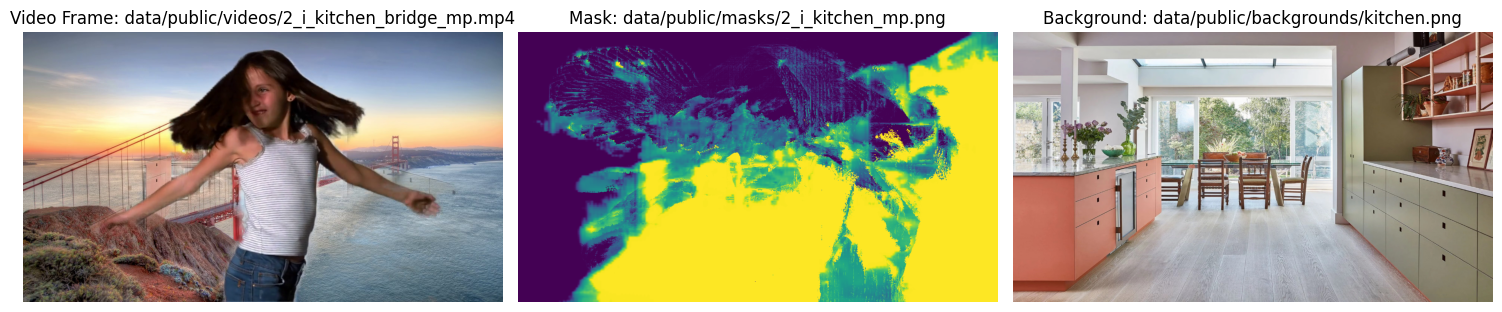

In [40]:
from matplotlib.pyplot import imshow, subplots
fig, ax = subplots(1, 3, figsize=(15, 5))
ax[0].imshow(video["video"][92, :, :, ::-1])
ax[1].imshow(video["mask"])
ax[2].imshow(video["background"][:, :, ::-1])
ax[0].set_title(f"Video Frame: {sample[0]}")
ax[1].set_title(f"Mask: {sample[1]}")
ax[2].set_title(f"Background: {sample[2]}")
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
plt.tight_layout()
plt.show()

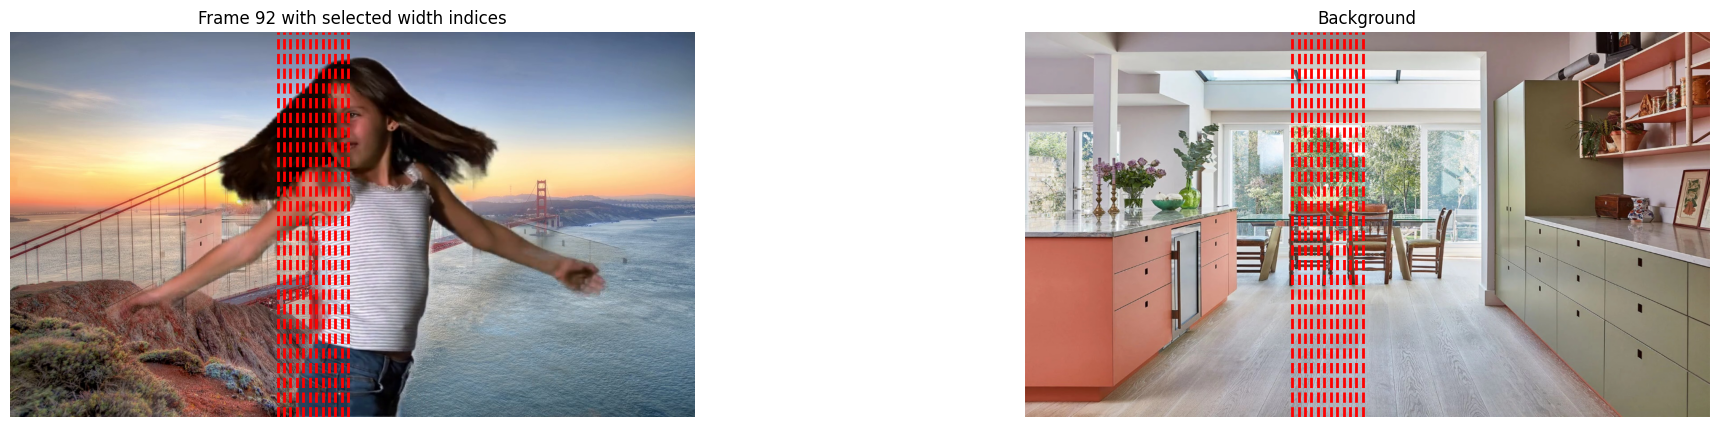

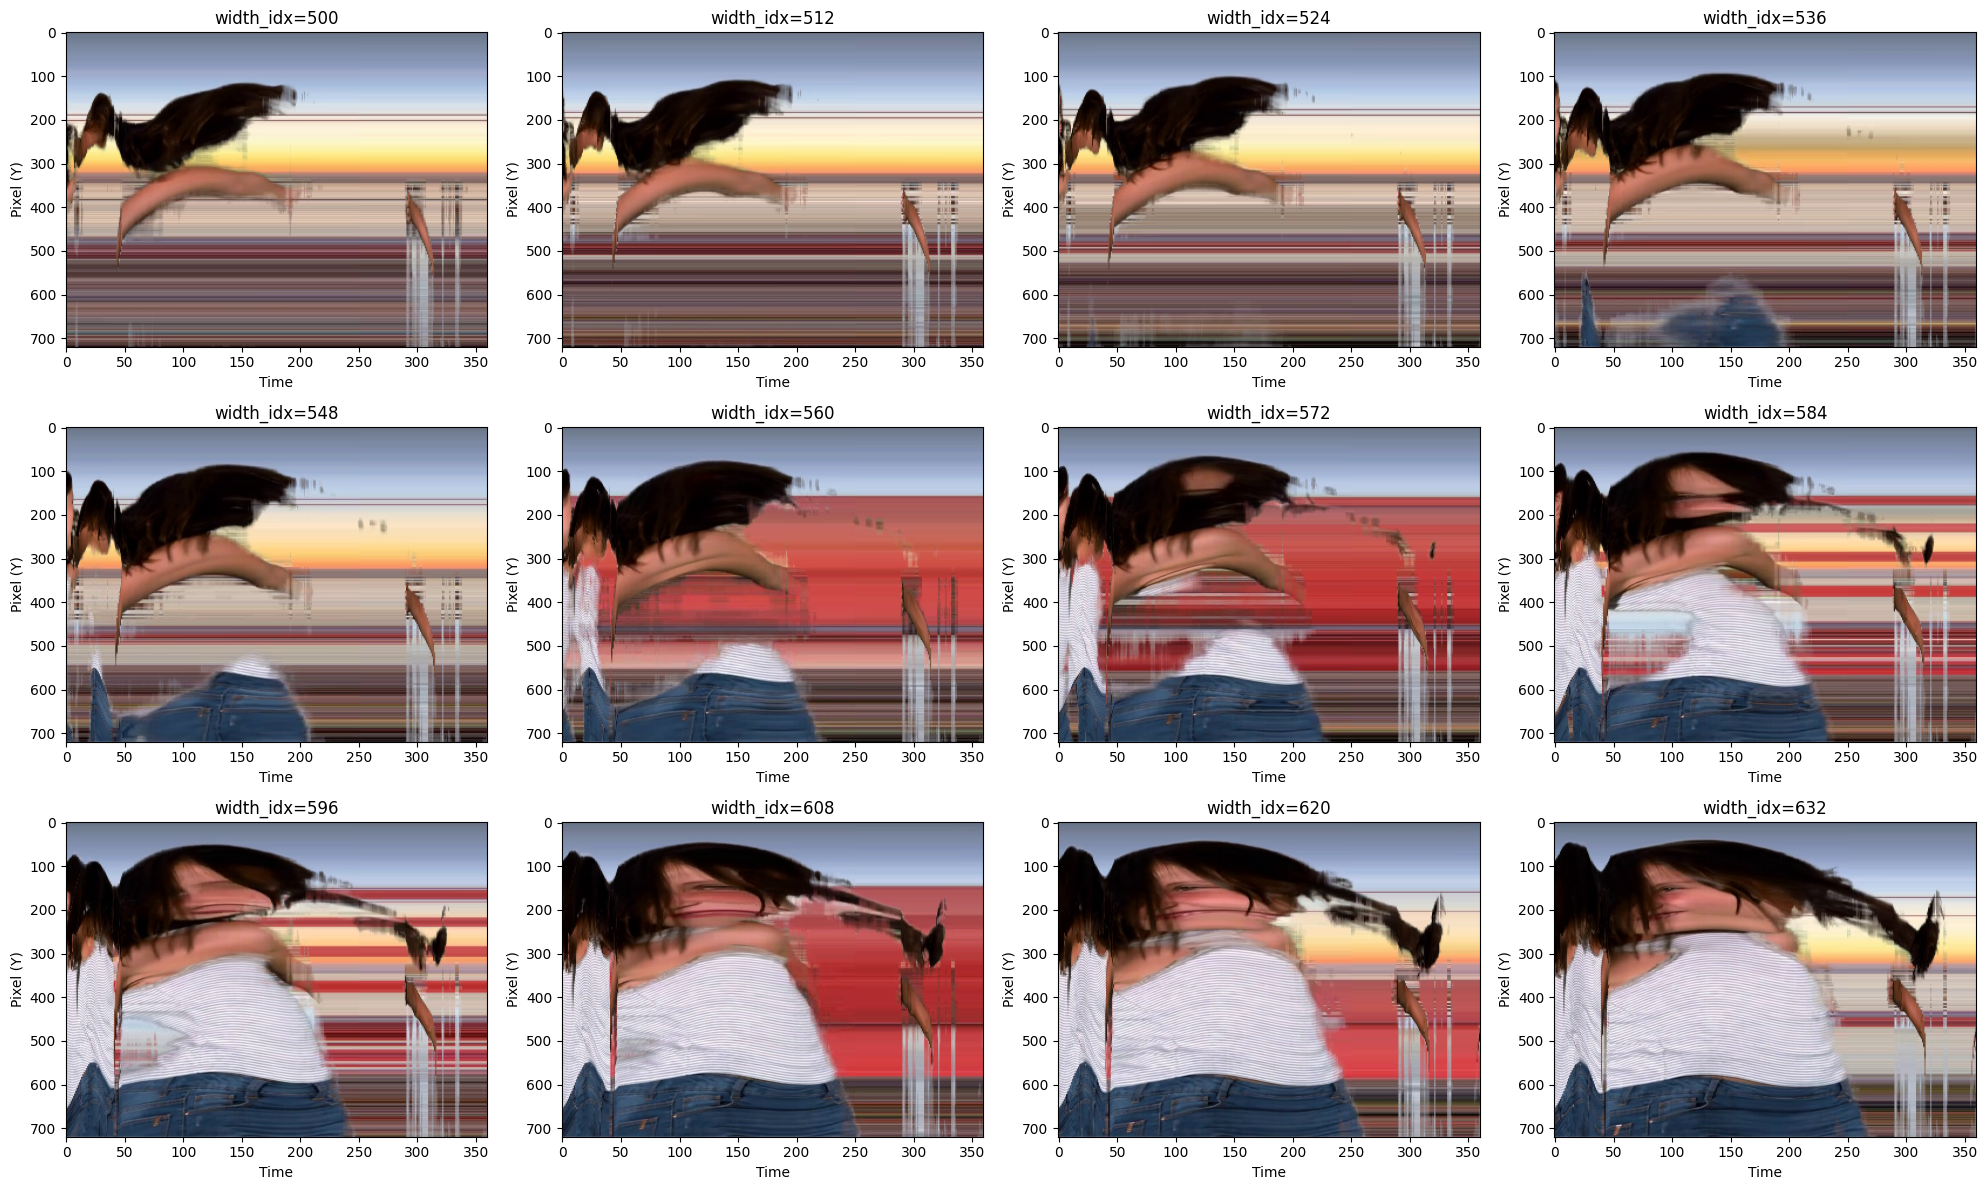

In [54]:
# Plot a reference frame and draw vertical lines for selected width indices

width_idx = 500

fig_ref, (ax_ref, ax_bg) = subplots(1, 2, figsize=(24, 5))
frame_idx = 92
# Left: reference frame with vertical lines
ax_ref.imshow(video["video"][frame_idx, :, :, ::-1])
for i in range(12):
    w_idx = width_idx + i*12
    ax_ref.axvline(x=w_idx, color='red', linestyle='--', linewidth=2)
ax_ref.set_title(f"Frame {frame_idx} with selected width indices")
ax_ref.axis("off")
# Right: background image
ax_bg.imshow(video["background"][:, :, ::-1])
for i in range(12):
    w_idx = width_idx + i*12
    ax_bg.axvline(x=w_idx, color='red', linestyle='--', linewidth=2)
ax_bg.set_title("Background")
ax_bg.axis("off")
plt.show()
# make video
# select the lower left pixel of the video
# Show 12 subplots (3 rows x 4 columns) for different width_idx values
fig, axes = subplots(3, 4, figsize=(20, 12))
for i in range(12):
    w_idx = width_idx + i*12
    pixels_over_time = video["video"][:, :, w_idx, ::-1]
    pixels = pixels_over_time.transpose(1, 0, 2)
    ax = axes[i // 4, i % 4]
    ax.imshow(pixels, aspect="auto")
    ax.set_xlabel("Time")
    ax.set_ylabel("Pixel (Y)")
    ax.set_title(f"width_idx={w_idx}")
plt.tight_layout()
plt.show()



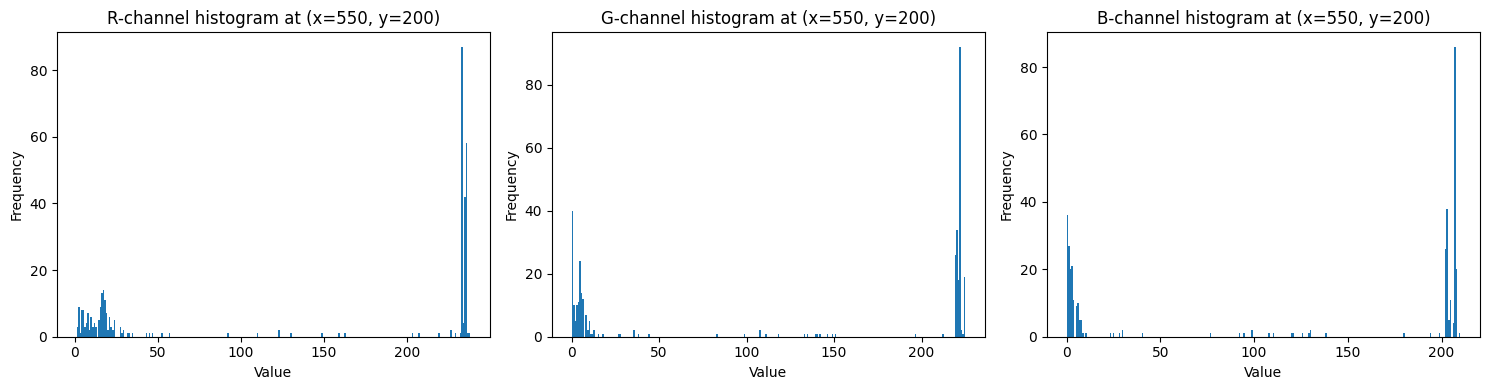

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# video: np.ndarray of shape (T, H, W, 3), in BGR order
# e.g. video = np.stack(load_video(...), axis=0)

# Coordinates
x, y = 550, 200

# Extract time‐series at that pixel, convert to RGB
pix_ts = video["video"][:, y, x, ::-1]  # shape (T,3)

# Plot
channels = ['R', 'G', 'B']
fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

for i, ch in enumerate(channels):
    axes[i].hist(pix_ts[:, i], bins=256)
    axes[i].set_title(f'{ch}-channel histogram at (x={x}, y={y})')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.show()


In [57]:
import numpy as np
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1) Grab your array and normalize to [0,1]
arr = video["video"].astype(np.float32) / 255.0  # shape: (T, H, W, 3)

T, H, W, _ = arr.shape
print(f"Video has {T} frames of size {W}x{H}")

# 2) Prepare the output image (uint8 RGB)
recon = np.zeros((H, W, 3), dtype=np.uint8)

# 3) Loop over every pixel and fit a 2-component GMM
for y in tqdm(range(H), desc="Rows"):
    for x in range(W):
        ts = arr[:, y, x, :]              # (T, 3) time-series at (x,y)
        uniq = np.unique(ts, axis=0)
        if len(uniq) < 2:
            # constant timeseries → no need to fit
            recon[y, x] = (uniq[0] * 255).round().astype(np.uint8)
            continue

        gmm = GaussianMixture(
            n_components=2,
            covariance_type="full",
            random_state=0,
            tol=1e-3,
            max_iter=100
        )
        gmm.fit(ts)
        # pick the smaller-weight component as “leaked real background”
        leak_idx = np.argmin(gmm.weights_)
        mean_rgb = (gmm.means_[leak_idx] * 255).round().astype(np.uint8)
        recon[y, x, :] = mean_rgb

# 4) Display as RGB
plt.figure(figsize=(10, 8))
plt.imshow(recon[..., ::-1])   # flip BGR→RGB
plt.title("Recovered Real Background via per-pixel 2-GMM")
plt.axis("off")
plt.show()


Video has 360 frames of size 1280x720


Rows:  19%|█▉        | 140/720 [12:00<49:44,  5.15s/it]  


KeyboardInterrupt: 

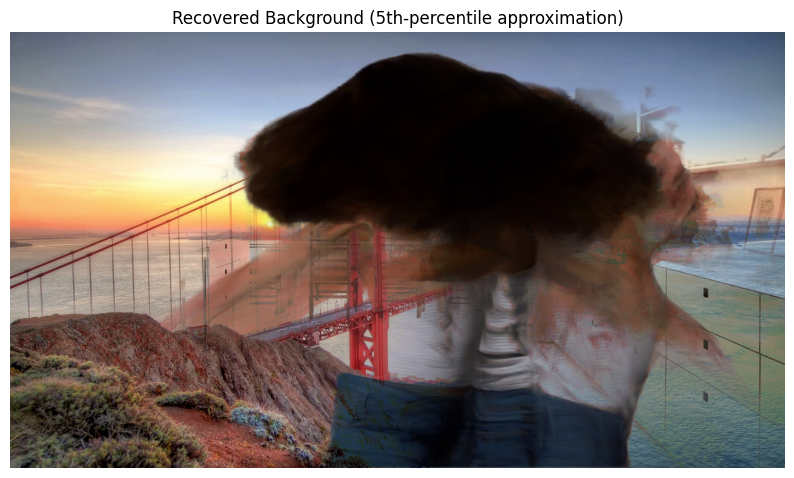

In [58]:
import torch
import matplotlib.pyplot as plt

# 1) Load your video into a torch tensor on the GPU
#    Suppose you have `video["video"]` as a NumPy array (T,H,W,3) in BGR uint8.
arr = torch.from_numpy(video["video"])            # (T, H, W, 3), uint8
arr = arr.to(torch.float32).cuda() / 255.0        # now float32 in [0,1], on GPU

# 2) Convert BGR→RGB in one op
arr = arr[..., [2,1,0]]                           # still (T,H,W,3)

# 3) Compute the 5th percentile along the time axis for each pixel & channel
#    Choose q=0.05 to pick the “rare” low‐frequency mode.
p = 0.05
perc = arr.kthvalue(
    k=max(1, int(arr.shape[0]*p)),    # kthvalue is 1-based; ensures at least 1
    dim=0,                           # reduce the time dimension
    keepdim=False
)[0]                                # result is (H,W,3)

# 4) Move back to CPU, convert to uint8
recovered = (perc.clamp(0,1) * 255).round().to(torch.uint8).cpu().numpy()

# 5) Display
plt.figure(figsize=(10,8))
plt.imshow(recovered)
plt.axis("off")
plt.title("Recovered Background (5th-percentile approximation)")
plt.show()


---

In [13]:
from scipy import stats
# display the video as an image using the mode over time (first axis is time, second is height, third is width, fourth is color)
def display_video(video, title="Video"):
    fig, ax = subplots(figsize=(10, 5))
    ax.imshow(video.transpose(1, 0, 2).astype(np.uint8), aspect='auto')
    ax.set_xlabel("Time")
    ax.set_ylabel("Height")
    ax.set_title(title)
    plt.show()

# display the video
print(type(video["video"]))
video_mode = stats.mode(video["video"], axis=0)
video_mode

video_median = np.median(video["video"], axis=0)

# calculate the upper percentile of the video
video_upper_percentile = np.percentile(video["video"], 75, axis=0)


<class 'numpy.ndarray'>


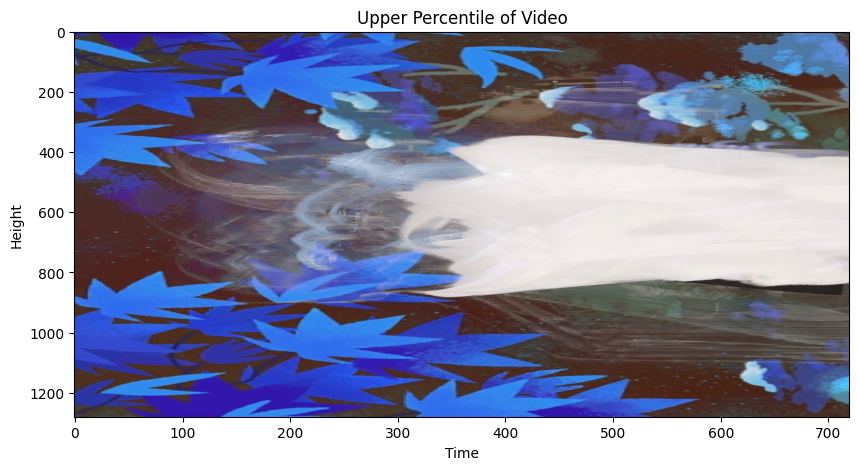

In [19]:
video_upper_percentile = np.percentile(video["video"], 99, axis=0).astype(np.uint8) 
display_video(video_upper_percentile, title="Upper Percentile of Video")

(720, 1280, 3)


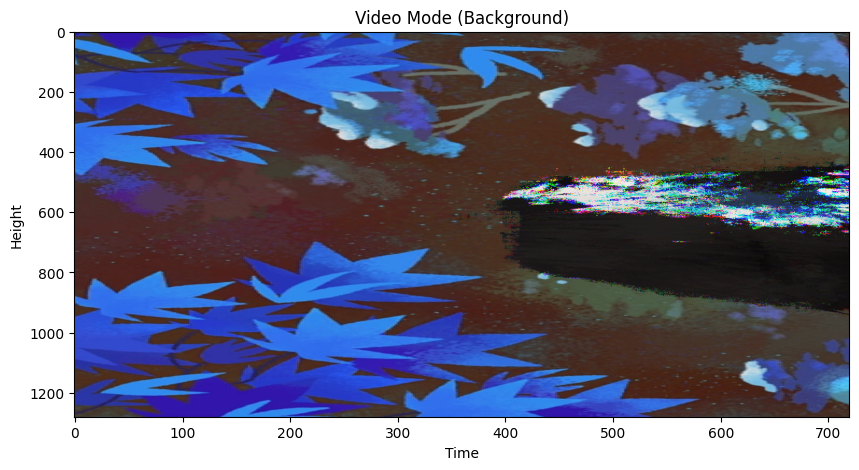

In [14]:
video_vbg = video_mode[0]
print(video_vbg.shape)  
# display the video with the mode over time
display_video(video_vbg, title="Video Mode (Background)")

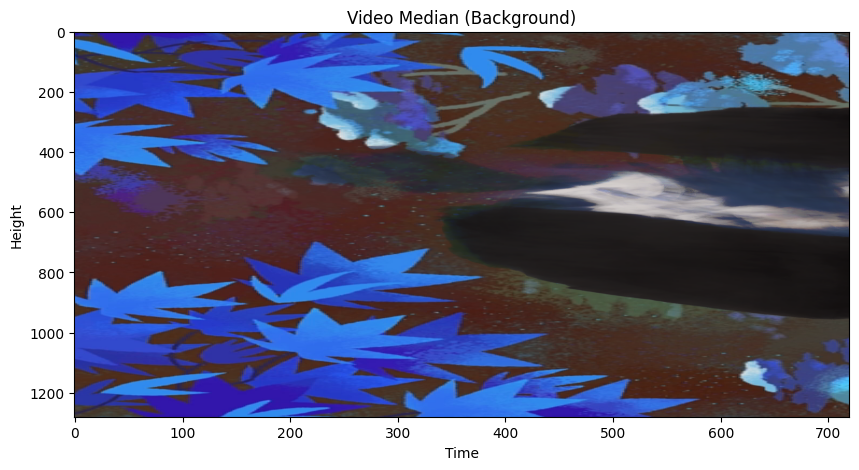

In [16]:
# display the median 
video_median = video_median.astype(np.uint8)
display_video(video_median, title="Video Median (Background)")

In [ ]:
# 

# This looks like an anomaly detection task to me!
### IDEA:
- Load triplets
- read frames
- build per-pixel colour stacks 
- Two-Cluster Test 
- Decide "Leak or not" 	If the minority component owns ≥min_frames (e.g. 3) and kl-divergence > τ, accept it
- Aggregate For accepted pixels, take the centroid of the minority cluster → recovered[i,j]
- Spatial Clean-up 3×3 majority filter + inpaint remaining NaNs (telea or poisson)
- Evaluation deltaE = metric_CIEDE2000(recovered, gt_background, gt_mask) → evaluate()






In [25]:
from util import metric_CIEDE2000, evaluate

reconstruction = load_background("img/reconstructed_background.png")

metric_out = metric_CIEDE2000(reconstruction, video["background"], video["mask"])
# print(f"Metric CIEDE2000: {metric_out}")
# evaluate the reconstruction
print(evaluate(metric_out, video["mask"]))


0.00798442953199
